In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
from PIL import Image

Read and grayscale

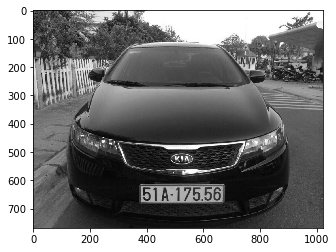

In [ ]:
img = cv2.imread('car4.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

Use threshold detection or edge detection

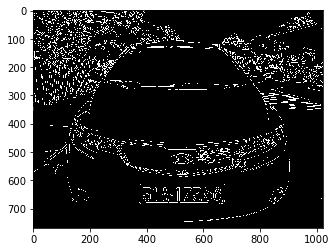

In [ ]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
# ret, threld = cv2.threshold(gray,127,255,cv2.THRESH_OTSU)
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))
# plt.imshow(cv2.cvtColor(threld, cv2.COLOR_BGR2RGB))

Find Contours and Apply Mask

In [ ]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [ ]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 4, True)
    if len(approx) == 4:
        location = approx
        break

In [ ]:
location

array([[[380, 620]],

       [[382, 677]],

       [[669, 675]],

       [[671, 620]]], dtype=int32)

In [ ]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

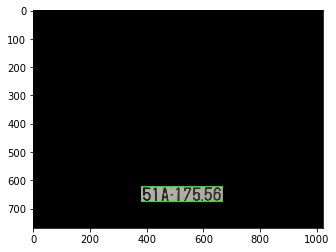

In [ ]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [ ]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

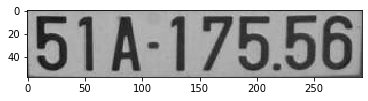

In [ ]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

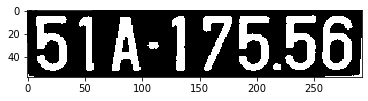

In [ ]:
binary = cv2.threshold(cropped_image, 127, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)[1]
plt.imshow(cv2.cvtColor(binary, cv2.COLOR_BGR2RGB))

In [ ]:
# binary2 = cv2.threshold(binary, 127, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)[1]
# plt.imshow(cv2.cvtColor(binary2, cv2.COLOR_BGR2RGB))

# Lisence plate

In [ ]:
kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

Detect 8 letters...


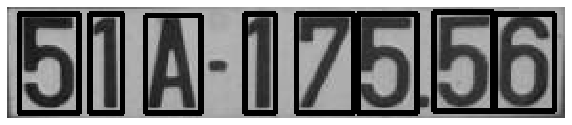

In [ ]:
# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = cropped_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 128, 128

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1.07<=ratio<=4.8333: # Only select contour with defined ratio
        if 0.5<=h/cropped_image.shape[0]<=1: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x-2, y-2), (x + w+2, y+h+2), (0, 255,0), 2)

            # Sperate number and gibe prediction
            curr_num = thre_mor[y-2:y+h+2,x-2:x+w+2]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)

print("Detect {} letters...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(cv2.cvtColor(test_roi, cv2.COLOR_BGR2RGB))


# Text recognition by correlation coefficient r-pearson

In [ ]:
def correlationCoefficient(X, Y):
    n = X.size
    sum_X = X.sum()
    sum_Y = Y.sum()
    sum_XY = (X*Y).sum()
    squareSum_X = (X*X).sum()
    squareSum_Y = (Y*Y).sum()
    corr = (n * sum_XY - sum_X * sum_Y)/(np.sqrt((n * squareSum_X - sum_X * sum_X)* (n * squareSum_Y - sum_Y * sum_Y))) 
    return corr

In [ ]:
def nhanDienKiTu(binary):
    # Use sample character set
    folder = r'/home/thinhds/Downloads/VScode/Letter/'
    list = []
    global textList
    global chuCai
    global text 
    text = ""
    img_bx = np.array(binary)/255
    for file in os.listdir(folder): 
        f_img = folder + file
        img2 = Image.open(f_img).convert("L")
        img2 = img2.resize((128,128))
        im2 = np.array(img2)/255
        prob = correlationCoefficient(img_bx, im2)
        list += [prob]
    for file in os.listdir(folder):
        f_img = folder + file
        img2 = Image.open(f_img).convert("L")
        img2 = img2.resize((128,128))
        im2 = np.array(img2)/255
        prob = correlationCoefficient(img_bx, im2)
        if prob == max(list):
            chuCai = file[0]
    return chuCai
textOutput = ""
for index in range(len(crop_characters)):
    binary = cv2.threshold(crop_characters[index], 127, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)[1] #chuyen thanh anh binary
    nhanDienKiTu(binary)
    textOutput += chuCai + " "
print(textOutput)

5 1 A 1 7 5 5 6 


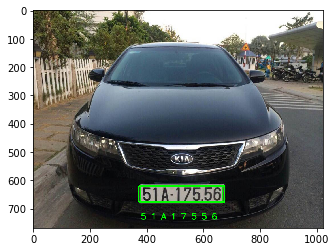

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX

res = cv2.putText(img, text=textOutput, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)

res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))